<a href="https://colab.research.google.com/github/NiyazovIlia/PyTorch-1/blob/lesson-3/HW_PyTorch_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание

Будем практиковаться на датасете недвижимости (sklearn.datasets.fetch_california_housing)

Ваша задача:
1. Создать Dataset для загрузки данных
2. Обернуть его в Dataloader
3. Написать архитектуру сети, которая предсказывает стоимость недвижимости. Сеть должна включать BatchNorm слои и Dropout (или НЕ включать, но нужно обосновать)
4. Сравните сходимость Adam, RMSProp и SGD, сделайте вывод по качеству работы модели

train-test разделение нужно сделать с помощью sklearn random_state=13, test_size = 0.25

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [2]:
houses = fetch_california_housing()

X = houses.data
Y = houses.target

X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=13, test_size = 0.25)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((15480, 8), (15480,), (5160, 8), (5160,))

In [3]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [4]:
class PriceHousing(torch.utils.data.Dataset):
   
    def __init__(self, data, target):
        self.data = torch.FloatTensor(data)
        self.target = torch.FloatTensor(target)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, ind):
        data, target = self.data[ind], self.target[ind]

        return data, target

In [5]:
train_data = PriceHousing(X_train, y_train)
test_data = PriceHousing(X_test, y_test)
print(f"Train: {len(train_data)}, test: {len(test_data)}")

Train: 15480, test: 5160


In [6]:
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=50, shuffle=True,
                                          num_workers=2, drop_last=True)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=50,
                                          shuffle=False)
print(f"Train: {len(train_dataloader)}, test: {len(test_dataloader)}")

Train: 309, test: 104


In [7]:
class Perceptron(nn.Module):
    def __init__(self, input_dim, output_dim, activation="relu"):
        super().__init__()
        self.fc = nn.Linear(input_dim, output_dim)
        self.activation = activation
        
    def forward(self, x):
        x = self.fc(x)
        if self.activation == "relu":
            return F.relu(x)
        if self.activation == "leaky_relu":
            return F.leaky_relu(x)
        raise RuntimeError
        

class FeedForward(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.fc1 = Perceptron(input_dim, 3*hidden_dim)
        self.bn1 = nn.BatchNorm1d(3*hidden_dim)
        self.dp1 = nn.Dropout(0.3)
        self.fc2 = Perceptron(3*hidden_dim, hidden_dim, "relu")
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.dp2 = nn.Dropout(0.3)
        self.fc3 = Perceptron(hidden_dim, 1, "relu")
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.dp1(x)
        x = self.bn1(x)
        x = self.fc2(x)
        x = self.dp2(x)
        x = self.bn2(x)
        x = self.fc3(x)
        return x

In [8]:
net = FeedForward(8, 774)

optimizers = {'Adam': torch.optim.Adam(net.parameters(), lr=0.01),
              'RMSProp': torch.optim.RMSprop(net.parameters(), lr=0.1, alpha=0.99), 
              'SGD': torch.optim.SGD(net.parameters(), lr=0.01)}

criterion = nn.MSELoss()

In [9]:
name = 'Adam'
optimizer = optimizers[name]

# сохраняем метрику трейна и теста для каждого оптимизатора
adam_train = []
adam_test = []

print(f"{20*'*'} Optimizer {name} {20*'*'}")

num_epochs = 10

for epoch in range(num_epochs):  
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    for i, data in enumerate(train_dataloader):
        inputs, answers = data[0], data[1]

        # обнуляем градиент
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, answers)
        # loss = loss.float()
        loss.backward()
        optimizer.step()

        # выводим статистику о процессе обучения
        true_variance = torch.var(answers)
        running_loss += loss.item()
        running_items += len(answers)
        # running_right += (answers == torch.max(outputs, 1)[1]).sum()
        
        # выводим статистику о процессе обучения
        if i % 150 == 0:    # печатаем каждые 300 mini-batches
            net.eval()
            MSE = running_loss / running_items
            R2 = 1 - MSE/true_variance
            adam_train.append(MSE)
            
            print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
                  f'Step [{i + 1}/{len(train_dataloader)}]. ' \
                  f'MSE: {MSE:.3f}. ' \
                  f'R2: {R2:.3f}', end='. ')

            running_loss, running_items, running_right = 0.0, 0.0, 0.0
            test_running_right, test_running_total, loss_test = 0.0, 0.0, 0.0

            for i, data in enumerate(test_dataloader):

                inputs_test, answers_test = data[0], data[1]

                test_outputs = net(inputs_test)
                loss_test += criterion(test_outputs.squeeze(), answers_test).item()
                test_running_total += len(answers_test)

                MSE_test = loss_test / test_running_total
                true_variance_test = torch.var(answers_test)

                R2_test = 1 - MSE_test/true_variance_test

            print(f'Test MSE: {MSE_test:.3f} Test R2: {R2_test:.3f}')
            # print(f'')
            adam_test.append(MSE_test)
            net.train()
    
print('Training is finished!')

******************** Optimizer Adam ********************


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([50])) that is different to the input size (torch.Size([50, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/10]. Step [1/309]. MSE: 0.081. R2: 0.937. Test MSE: 0.093 Test R2: 0.953
Epoch [1/10]. Step [151/309]. MSE: 0.039. R2: 0.979. Test MSE: 0.034 Test R2: 0.983
Epoch [1/10]. Step [301/309]. MSE: 0.027. R2: 0.981. Test MSE: 1.316 Test R2: 0.335
Epoch [2/10]. Step [1/309]. MSE: 0.030. R2: 0.980. Test MSE: 1.916 Test R2: 0.032
Epoch [2/10]. Step [151/309]. MSE: 0.027. R2: 0.980. Test MSE: 0.872 Test R2: 0.559
Epoch [2/10]. Step [301/309]. MSE: 0.027. R2: 0.982. Test MSE: 0.119 Test R2: 0.940
Epoch [3/10]. Step [1/309]. MSE: 0.024. R2: 0.980. Test MSE: 0.227 Test R2: 0.885
Epoch [3/10]. Step [151/309]. MSE: 0.027. R2: 0.979. Test MSE: 0.028 Test R2: 0.986
Epoch [3/10]. Step [301/309]. MSE: 0.027. R2: 0.976. Test MSE: 0.033 Test R2: 0.984
Epoch [4/10]. Step [1/309]. MSE: 0.031. R2: 0.980. Test MSE: 0.029 Test R2: 0.985
Epoch [4/10]. Step [151/309]. MSE: 0.026. R2: 0.980. Test MSE: 0.029 Test R2: 0.986
Epoch [4/10]. Step [301/309]. MSE: 0.027. R2: 0.977. Test MSE: 0.027 Test R2: 0.986


In [10]:
name = 'RMSProp'

optimizer = optimizers[name]

# сохраняем метрику трейна и теста для каждого оптимизатора
RMSProp_train = []
RMSProp_test = []

print(f"{20*'*'} Optimizer {name} {20*'*'}")

num_epochs = 10

for epoch in range(num_epochs):  
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    for i, data in enumerate(train_dataloader):
        inputs, answers = data[0], data[1]

        # обнуляем градиент
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, answers)
        # loss = loss.float()
        loss.backward()
        optimizer.step()

        # выводим статистику о процессе обучения
        true_variance = torch.var(answers)
        running_loss += loss.item()
        running_items += len(answers)
        # running_right += (answers == torch.max(outputs, 1)[1]).sum()
        
        # выводим статистику о процессе обучения
        if i % 150 == 0:    # печатаем каждые 300 mini-batches
            net.eval()
            MSE = running_loss / running_items
            R2 = 1 - MSE/true_variance
            RMSProp_train.append(MSE)
            
            print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
                  f'Step [{i + 1}/{len(train_dataloader)}]. ' \
                  f'MSE: {MSE:.3f}. ' \
                  f'R2: {R2:.3f}', end='. ')

            running_loss, running_items, running_right = 0.0, 0.0, 0.0
            test_running_right, test_running_total, loss_test = 0.0, 0.0, 0.0

            for i, data in enumerate(test_dataloader):

                inputs_test, answers_test = data[0], data[1]

                test_outputs = net(inputs_test)
                loss_test += criterion(test_outputs.squeeze(), answers_test).item()
                test_running_total += len(answers_test)

                MSE_test = loss_test / test_running_total
                true_variance_test = torch.var(answers_test)

                R2_test = 1 - MSE_test/true_variance_test

            print(f'Test MSE: {MSE_test:.3f} Test R2: {R2_test:.3f}')
            # print(f'')
            RMSProp_test.append(MSE_test)
            net.train()
    
print('Training is finished!')

******************** Optimizer RMSProp ********************
Epoch [1/10]. Step [1/309]. MSE: 0.034. R2: 0.980. 

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([50])) that is different to the input size (torch.Size([50, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test MSE: 0.114 Test R2: 0.942
Epoch [1/10]. Step [151/309]. MSE: 0.112. R2: 0.861. Test MSE: 64.300 Test R2: -31.497
Epoch [1/10]. Step [301/309]. MSE: 0.112. R2: 0.893. Test MSE: 30.235 Test R2: -14.281
Epoch [2/10]. Step [1/309]. MSE: 0.136. R2: 0.924. Test MSE: 6.019 Test R2: -2.042
Epoch [2/10]. Step [151/309]. MSE: 0.111. R2: 0.897. Test MSE: 28.350 Test R2: -13.328
Epoch [2/10]. Step [301/309]. MSE: 0.113. R2: 0.907. Test MSE: 83.713 Test R2: -41.309
Epoch [3/10]. Step [1/309]. MSE: 0.098. R2: 0.923. Test MSE: 107.981 Test R2: -53.574
Epoch [3/10]. Step [151/309]. MSE: 0.112. R2: 0.893. Test MSE: 90.287 Test R2: -44.631
Epoch [3/10]. Step [301/309]. MSE: 0.112. R2: 0.910. Test MSE: 57.942 Test R2: -28.284
Epoch [4/10]. Step [1/309]. MSE: 0.093. R2: 0.913. Test MSE: 14.293 Test R2: -6.224
Epoch [4/10]. Step [151/309]. MSE: 0.114. R2: 0.911. Test MSE: 65.613 Test R2: -32.161
Epoch [4/10]. Step [301/309]. MSE: 0.111. R2: 0.937. Test MSE: 10.638 Test R2: -4.376
Epoch [5/10]. Step [1

In [11]:
name = 'SGD'

optimizer = optimizers[name]

# сохраняем метрику трейна и теста для каждого оптимизатора
SGD_train = []
SGD_test = []

print(f"{20*'*'} Optimizer {name} {20*'*'}")

num_epochs = 10

for epoch in range(num_epochs):  
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    for i, data in enumerate(train_dataloader):
        inputs, answers = data[0], data[1]

        # обнуляем градиент
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, answers)
        # loss = loss.float()
        loss.backward()
        optimizer.step()

        # выводим статистику о процессе обучения
        true_variance = torch.var(answers)
        running_loss += loss.item()
        running_items += len(answers)
        # running_right += (answers == torch.max(outputs, 1)[1]).sum()
        
        # выводим статистику о процессе обучения
        if i % 150 == 0:    # печатаем каждые 300 mini-batches
            net.eval()
            MSE = running_loss / running_items
            R2 = 1 - MSE/true_variance
            SGD_train.append(MSE)
            
            print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
                  f'Step [{i + 1}/{len(train_dataloader)}]. ' \
                  f'MSE: {MSE:.3f}. ' \
                  f'R2: {R2:.3f}', end='. ')

            running_loss, running_items, running_right = 0.0, 0.0, 0.0
            test_running_right, test_running_total, loss_test = 0.0, 0.0, 0.0

            for i, data in enumerate(test_dataloader):

                inputs_test, answers_test = data[0], data[1]

                test_outputs = net(inputs_test)
                loss_test += criterion(test_outputs.squeeze(), answers_test).item()
                test_running_total += len(answers_test)

                MSE_test = loss_test / test_running_total
                true_variance_test = torch.var(answers_test)

                R2_test = 1 - MSE_test/true_variance_test

            print(f'Test MSE: {MSE_test:.3f} Test R2: {R2_test:.3f}')
            # print(f'')
            SGD_test.append(MSE_test)
            net.train()
    
print('Training is finished!')

******************** Optimizer SGD ********************
Epoch [1/10]. Step [1/309]. MSE: 0.141. R2: 0.917. 

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([50])) that is different to the input size (torch.Size([50, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test MSE: 2.313 Test R2: -0.169
Epoch [1/10]. Step [151/309]. MSE: 0.110. R2: 0.926. Test MSE: 87.172 Test R2: -43.057
Epoch [1/10]. Step [301/309]. MSE: 0.113. R2: 0.918. Test MSE: 41.198 Test R2: -19.822
Epoch [2/10]. Step [1/309]. MSE: 0.127. R2: 0.918. Test MSE: 75.728 Test R2: -37.273
Epoch [2/10]. Step [151/309]. MSE: 0.112. R2: 0.918. Test MSE: 9.243 Test R2: -3.672
Epoch [2/10]. Step [301/309]. MSE: 0.111. R2: 0.923. Test MSE: 69.692 Test R2: -34.222
Epoch [3/10]. Step [1/309]. MSE: 0.090. R2: 0.914. Test MSE: 81.478 Test R2: -40.179
Epoch [3/10]. Step [151/309]. MSE: 0.113. R2: 0.921. Test MSE: 144.716 Test R2: -72.140
Epoch [3/10]. Step [301/309]. MSE: 0.110. R2: 0.924. Test MSE: 16.855 Test R2: -7.519
Epoch [4/10]. Step [1/309]. MSE: 0.138. R2: 0.921. Test MSE: 62.979 Test R2: -30.830
Epoch [4/10]. Step [151/309]. MSE: 0.113. R2: 0.923. Test MSE: 43.035 Test R2: -20.750
Epoch [4/10]. Step [301/309]. MSE: 0.112. R2: 0.906. Test MSE: 10.879 Test R2: -4.498
Epoch [5/10]. Step [

[]

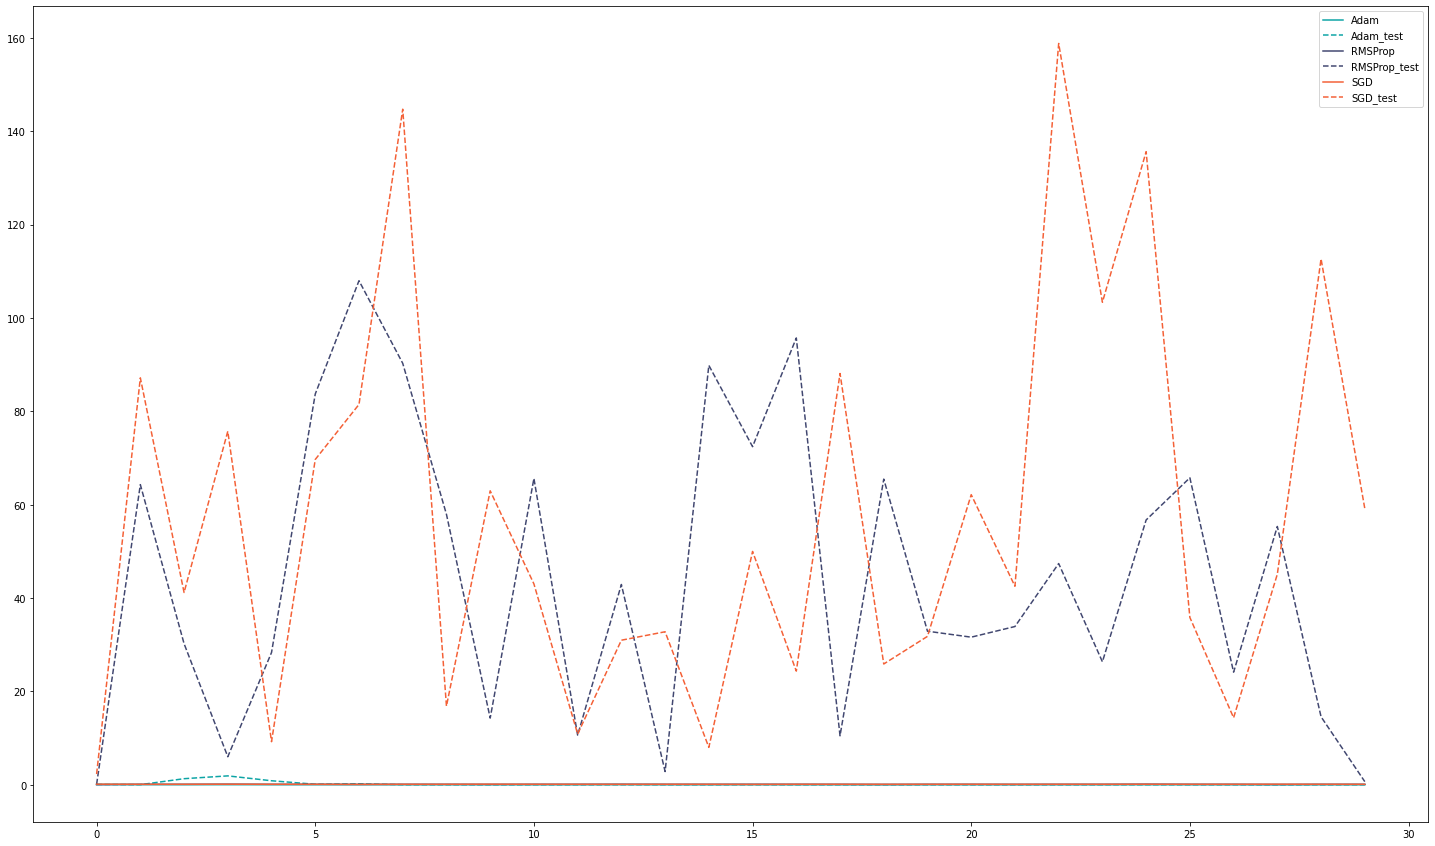

In [13]:
plt.figure(figsize=(25,15))

x_train = np.arange(len(adam_train))
x_test = np.arange(len(adam_test))

plt.plot(x_train, adam_train, linestyle='-' , color='#0CA4A5', label='Adam')
plt.plot(x_test, adam_test, linestyle='--' , color='#0CA4A5', label='Adam_test')

plt.plot(x_train, RMSProp_train, linestyle='-' , color='#414770', label='RMSProp')
plt.plot(x_test, RMSProp_test, linestyle='--' , color='#414770', label='RMSProp_test')

plt.plot(x_train, SGD_train, linestyle='-' , color='#F46036', label='SGD')
plt.plot(x_test, SGD_test, linestyle='--' , color='#F46036', label='SGD_test')

plt.legend()

plt.plot()